# Organizing multiple subplots

In [33]:
%%capture
%load_ext autoreload
%autoreload 2
from antarctic_plots import fetch, utils, maps, regions, profile
import pygmt

define a region to plot

In [34]:
plot_region = regions.ross_ice_shelf

create a dictionary of grids names

In [35]:
%%capture

ice_thickness = fetch.bedmachine(region=plot_region, layer="thickness")
GHF = fetch.ghf(region=plot_region, version="burton-johnson-2020")
crustal_thickness = fetch.crustal_thickness(region=plot_region, version="shen-2018")
FA_grav = fetch.gravity(region=plot_region, version="antgg-update", anomaly_type="FA")
BA_grav = fetch.gravity(region=plot_region, version="antgg-update", anomaly_type="BA")
basement = fetch.basement(region=plot_region)

grids = [
    ice_thickness,
    GHF,
    crustal_thickness,
    FA_grav,
    BA_grav,
    basement,
]

## Plot the grids
By default, `maps.subplots` will try to create a square of subplots from the supplied list of grids. You can also set parameter `dims=(number of rows, number of columns)` to customize this. If is the resulting subplots with the defaults:

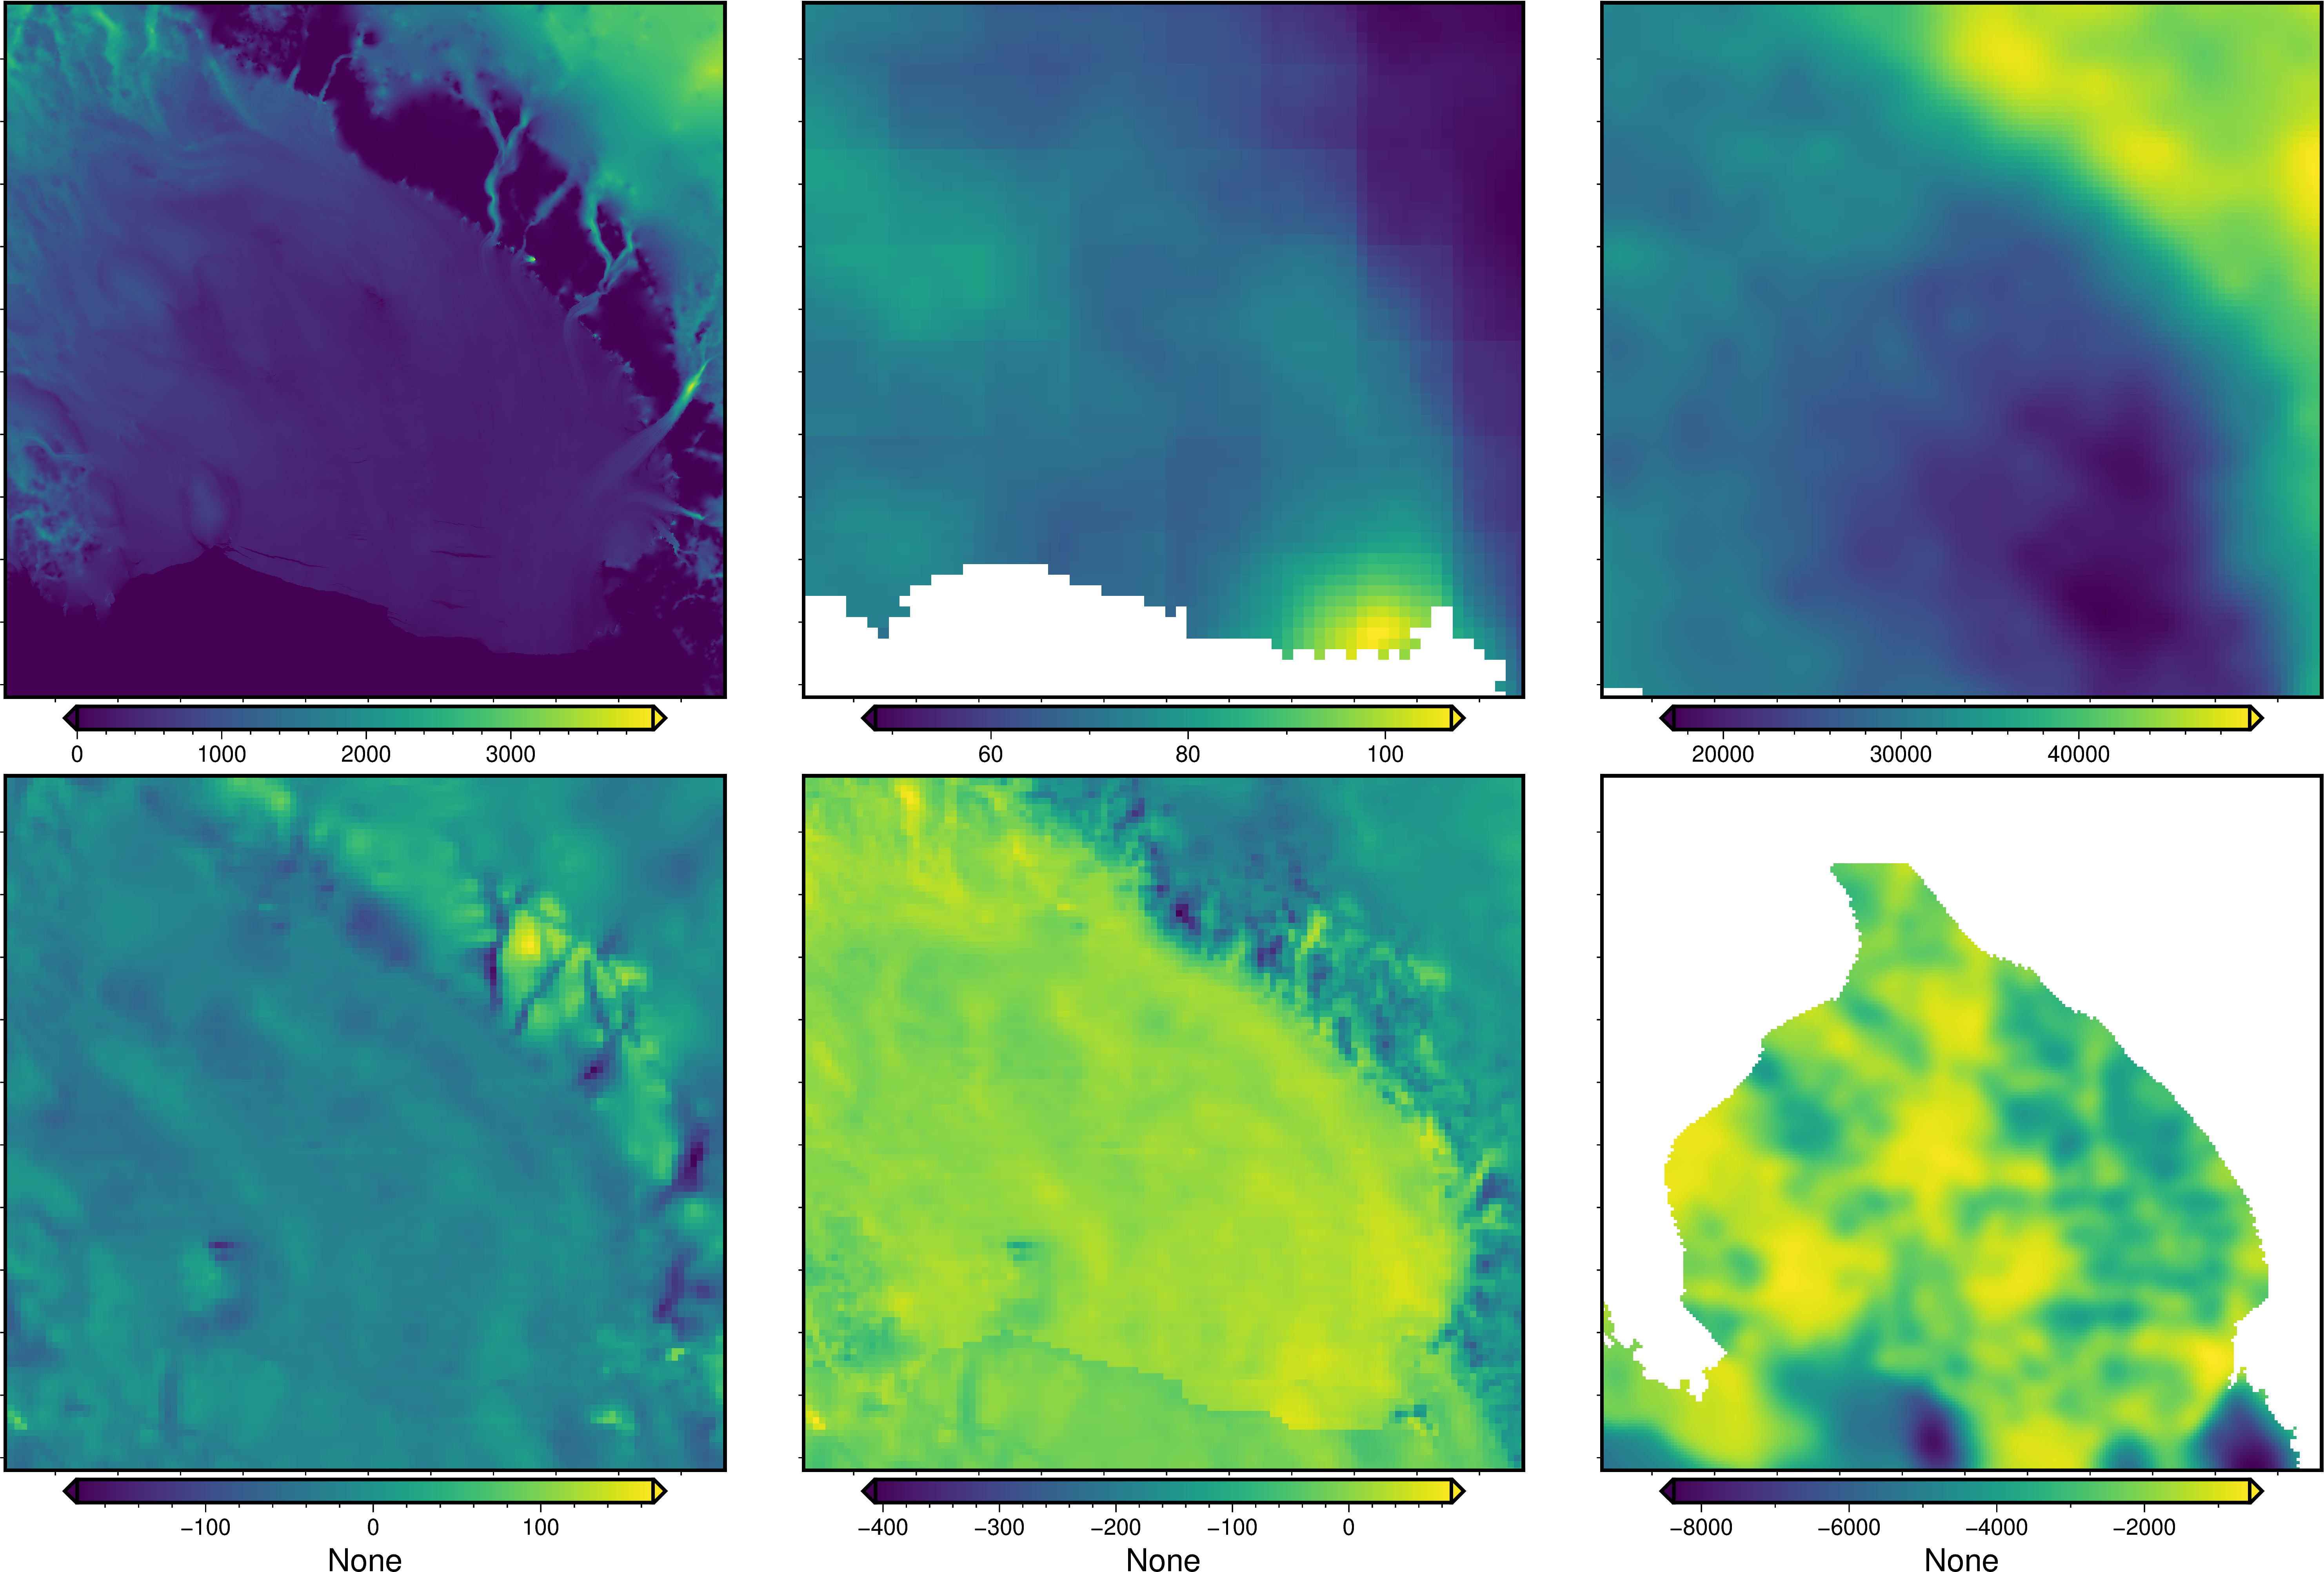

In [24]:
fig = maps.subplots(grids)
fig.show()

Here are some of the keyword arguments you can provide to customize the plots:

In [39]:
fig = maps.subplots(
    grids,
    plot_region,
    margins="1.5c",
    coast=True,
    fig_title="Plotting multiple grids",
    subplot_titles=[
        "Ice thickness",
        "GHF",
        "Crustal thickness",
        "Free-air gravity",
        "Bouguer gravity",
        "Basement elevation",
    ],
    cmaps=[
        "deep",
        "solar",
        "thermal",
        "balance+h0",
        "balance+h0",
        "batlow",
    ],
    cbar_labels=[
        "BedMachine v1",
        "Burton-Johnson et al. 2020",
        "Shen et al. 2018",
        "Forsberg et al. 2020",
        "Forsberg et al. 2020",
        "Tankersley et al. 2022",
    ],
    cbar_units=["m", "mW/m²", "m", "mGal", "mGal", "m"],
    autolabel=True,
)

# save the figure to use in the Gallery examples
fig.savefig("outputs/subplot_layout.png")

fig.show()

subplot [ERROR]: No subplot information file found!
subplot [ERROR]: Unable to open file C:/Users/matthewt/.gmt/sessions/gmt_session.22448/gmt.subplotorder.1!
subplot [ERROR]: No subplot information file!


GMTCLibError: Module 'subplot' failed with status code 15:
subplot [ERROR]: No subplot information file!

If you want to further customize the plots, it might be better to use the built-in PyGMT subplot function, and set `origin_shift='no_shift'`.

To help organize titles and grids, we can add everything to a dictionary.  
Here we add titles, a shapefile, and a legend.

In [29]:
layers = {
    "Ice thickness": {
        "grid": ice_thickness,
    },
    "GHF": {"grid": GHF},
    "Crustal thickness": {"grid": crustal_thickness},
    "Free-air gravity": {"grid": FA_grav},
    "Bouguer gravity": {"grid": BA_grav},
    "Basement elevation": {"grid": basement},
}

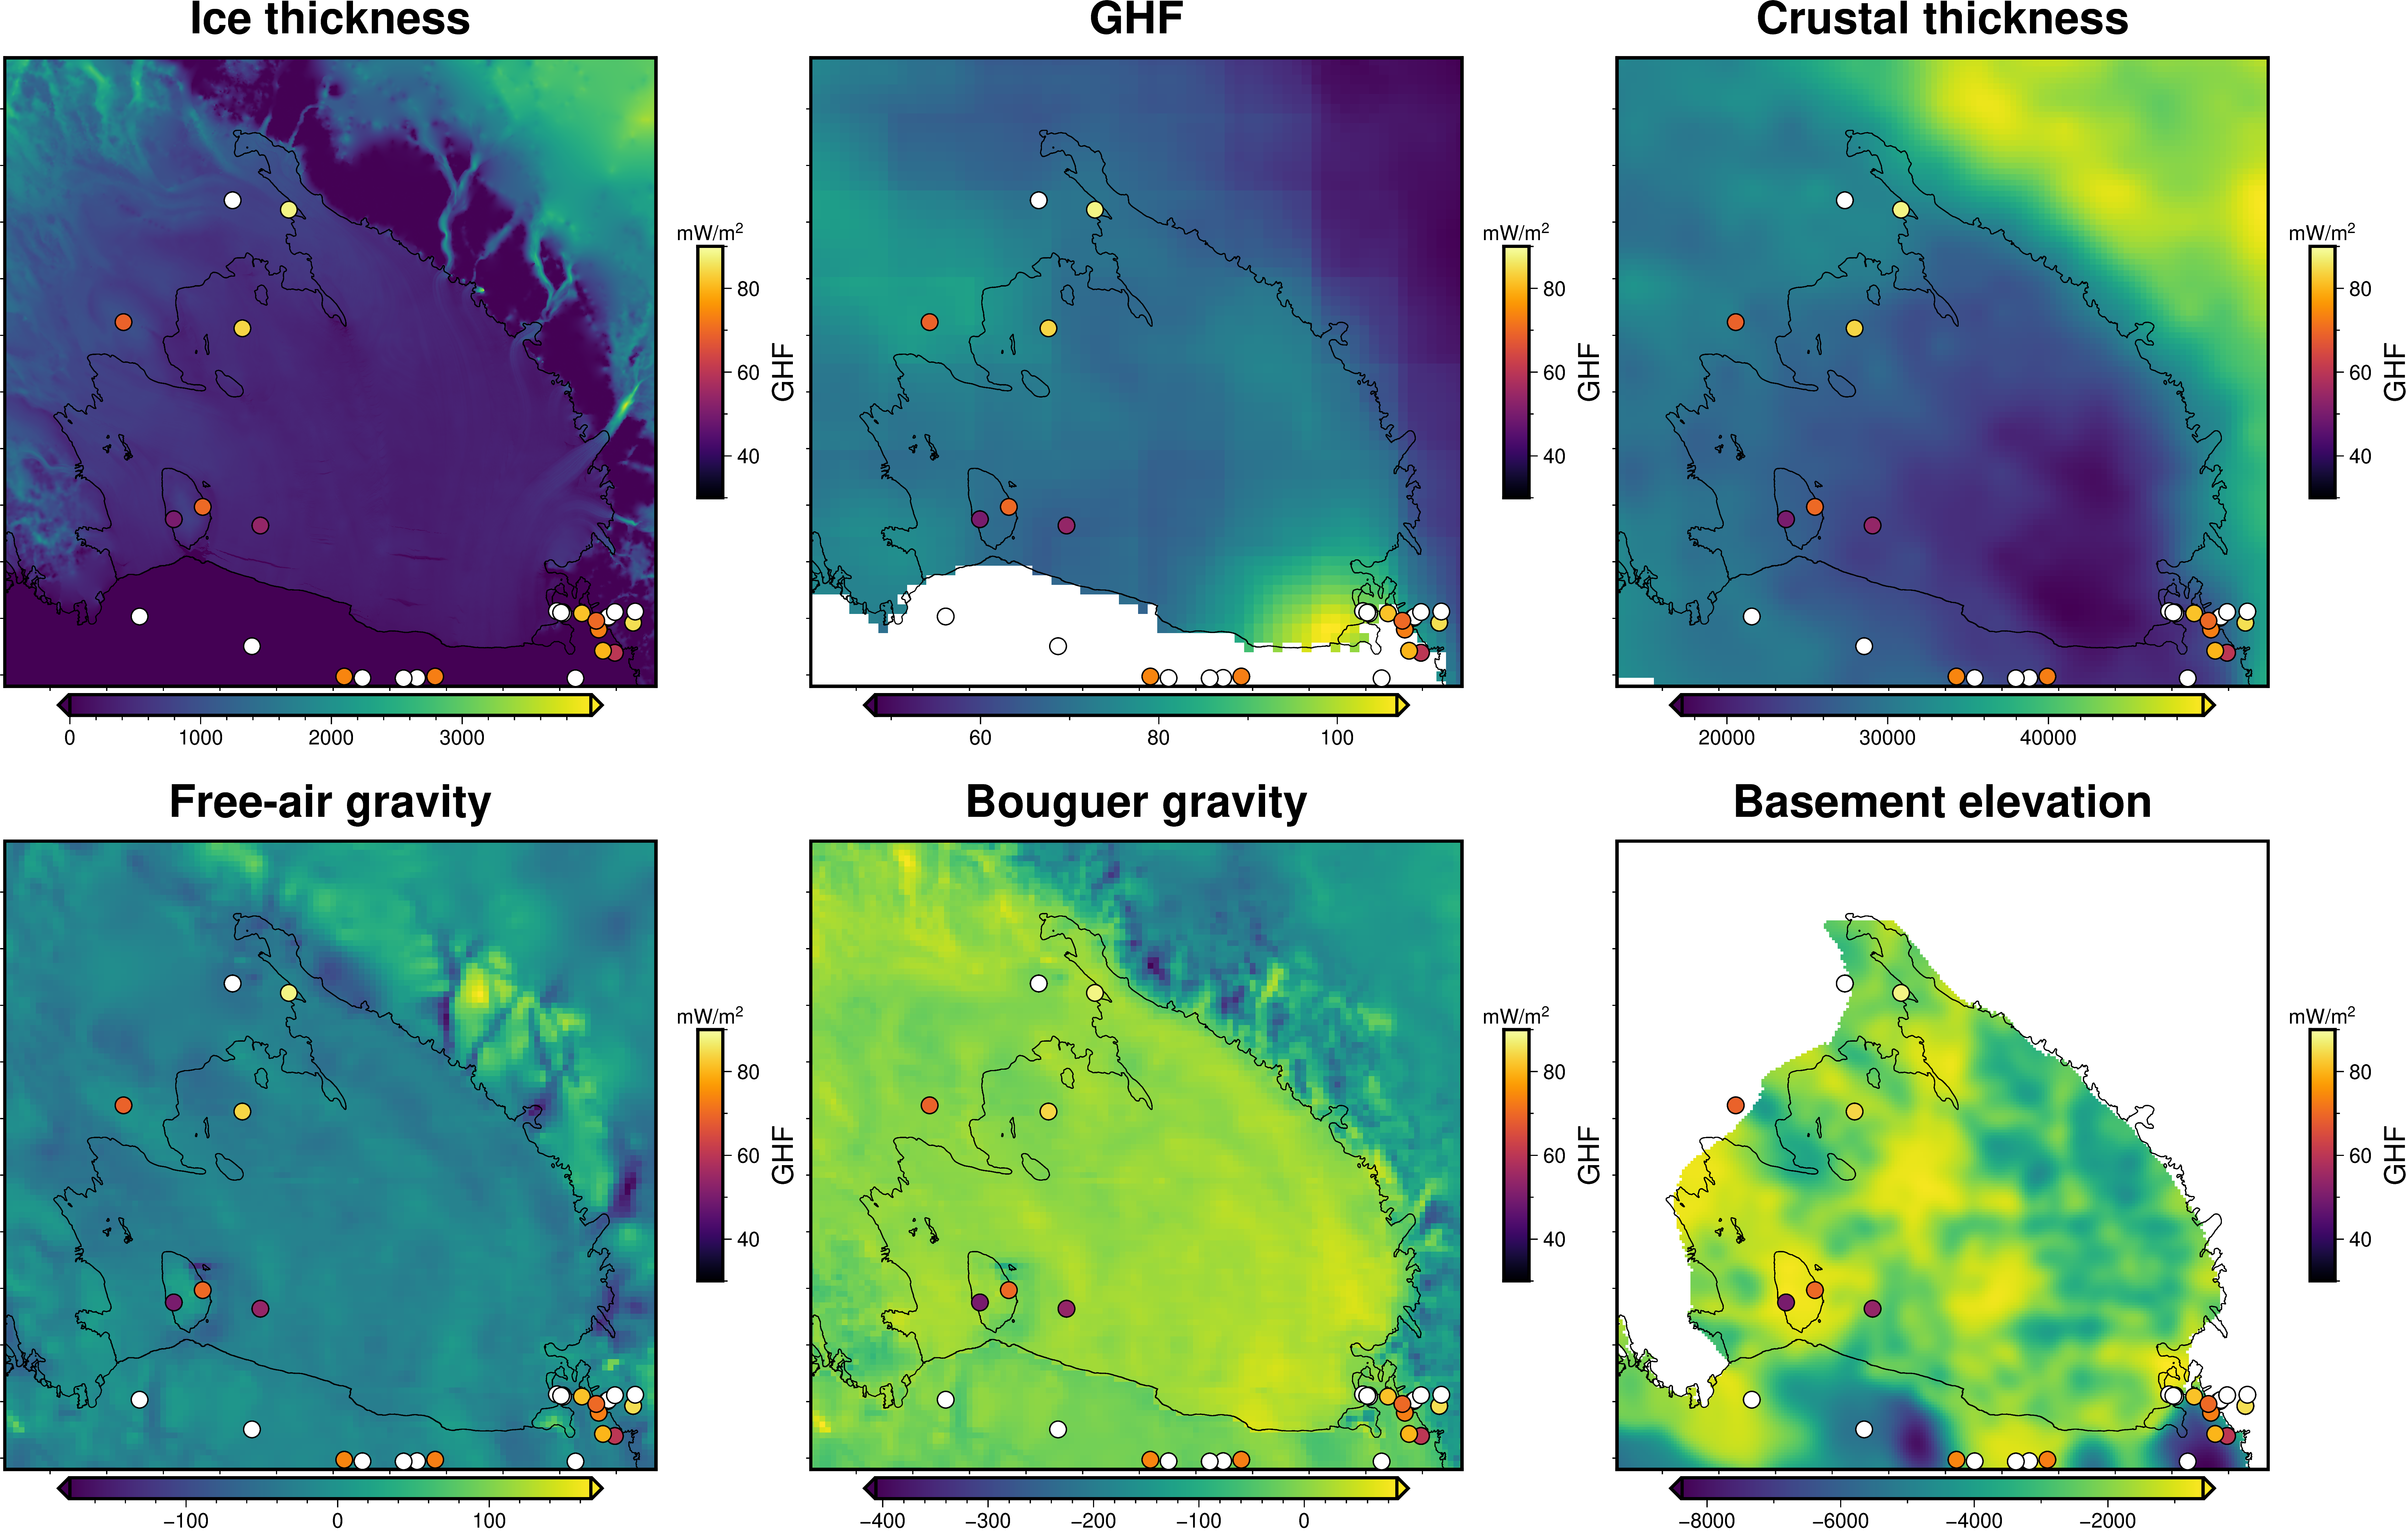

In [30]:
subplot_dimensions = utils.square_subplots(len(layers.items()))

proj, proj_latlon, fig_width, fig_height = utils.set_proj(plot_region, 15)

fig = pygmt.Figure()

# fetch GHF data
df = fetch.ghf(version="burton-johnson-2020", points=True)

with fig.subplot(
    nrows=subplot_dimensions[0],
    ncols=subplot_dimensions[1],
    subsize=(fig_width, fig_height),
    frame="f",
    margins="1.5c",
):
    for i, (k, v) in enumerate(layers.items()):
        with fig.set_panel(panel=i):
            # plot the grids
            maps.plot_grd(
                v["grid"],
                fig=fig,
                title=k,
                origin_shift="no_shift",
                region=plot_region,
                coast=True,
            )
            # plot GHF point measurements
            # make a colorscale
            pygmt.makecpt(cmap="inferno", series=[30, 90])
            # plot the points
            fig.plot(
                x=df.x,
                y=df.y,
                color=df.GHF,
                cmap=True,
                pen=".8p,black",
                style="c.4c",
            )
            # add a colorbar
            fig.colorbar(
                position="JMR+o1c/0c+w6c/.6c", frame=["x+lGHF", "y+lmW/m@+2@+"]
            )

fig.show()

Alternatively, if you create your own layout by using the `origin_shift` parameter of `maps.plot_grid`.

Use kwargs `xshift_amount` and `yshift_amount` to give number of figs to shift origin by. (e.g. `xshift_amount=3` would be 3 figure widths)

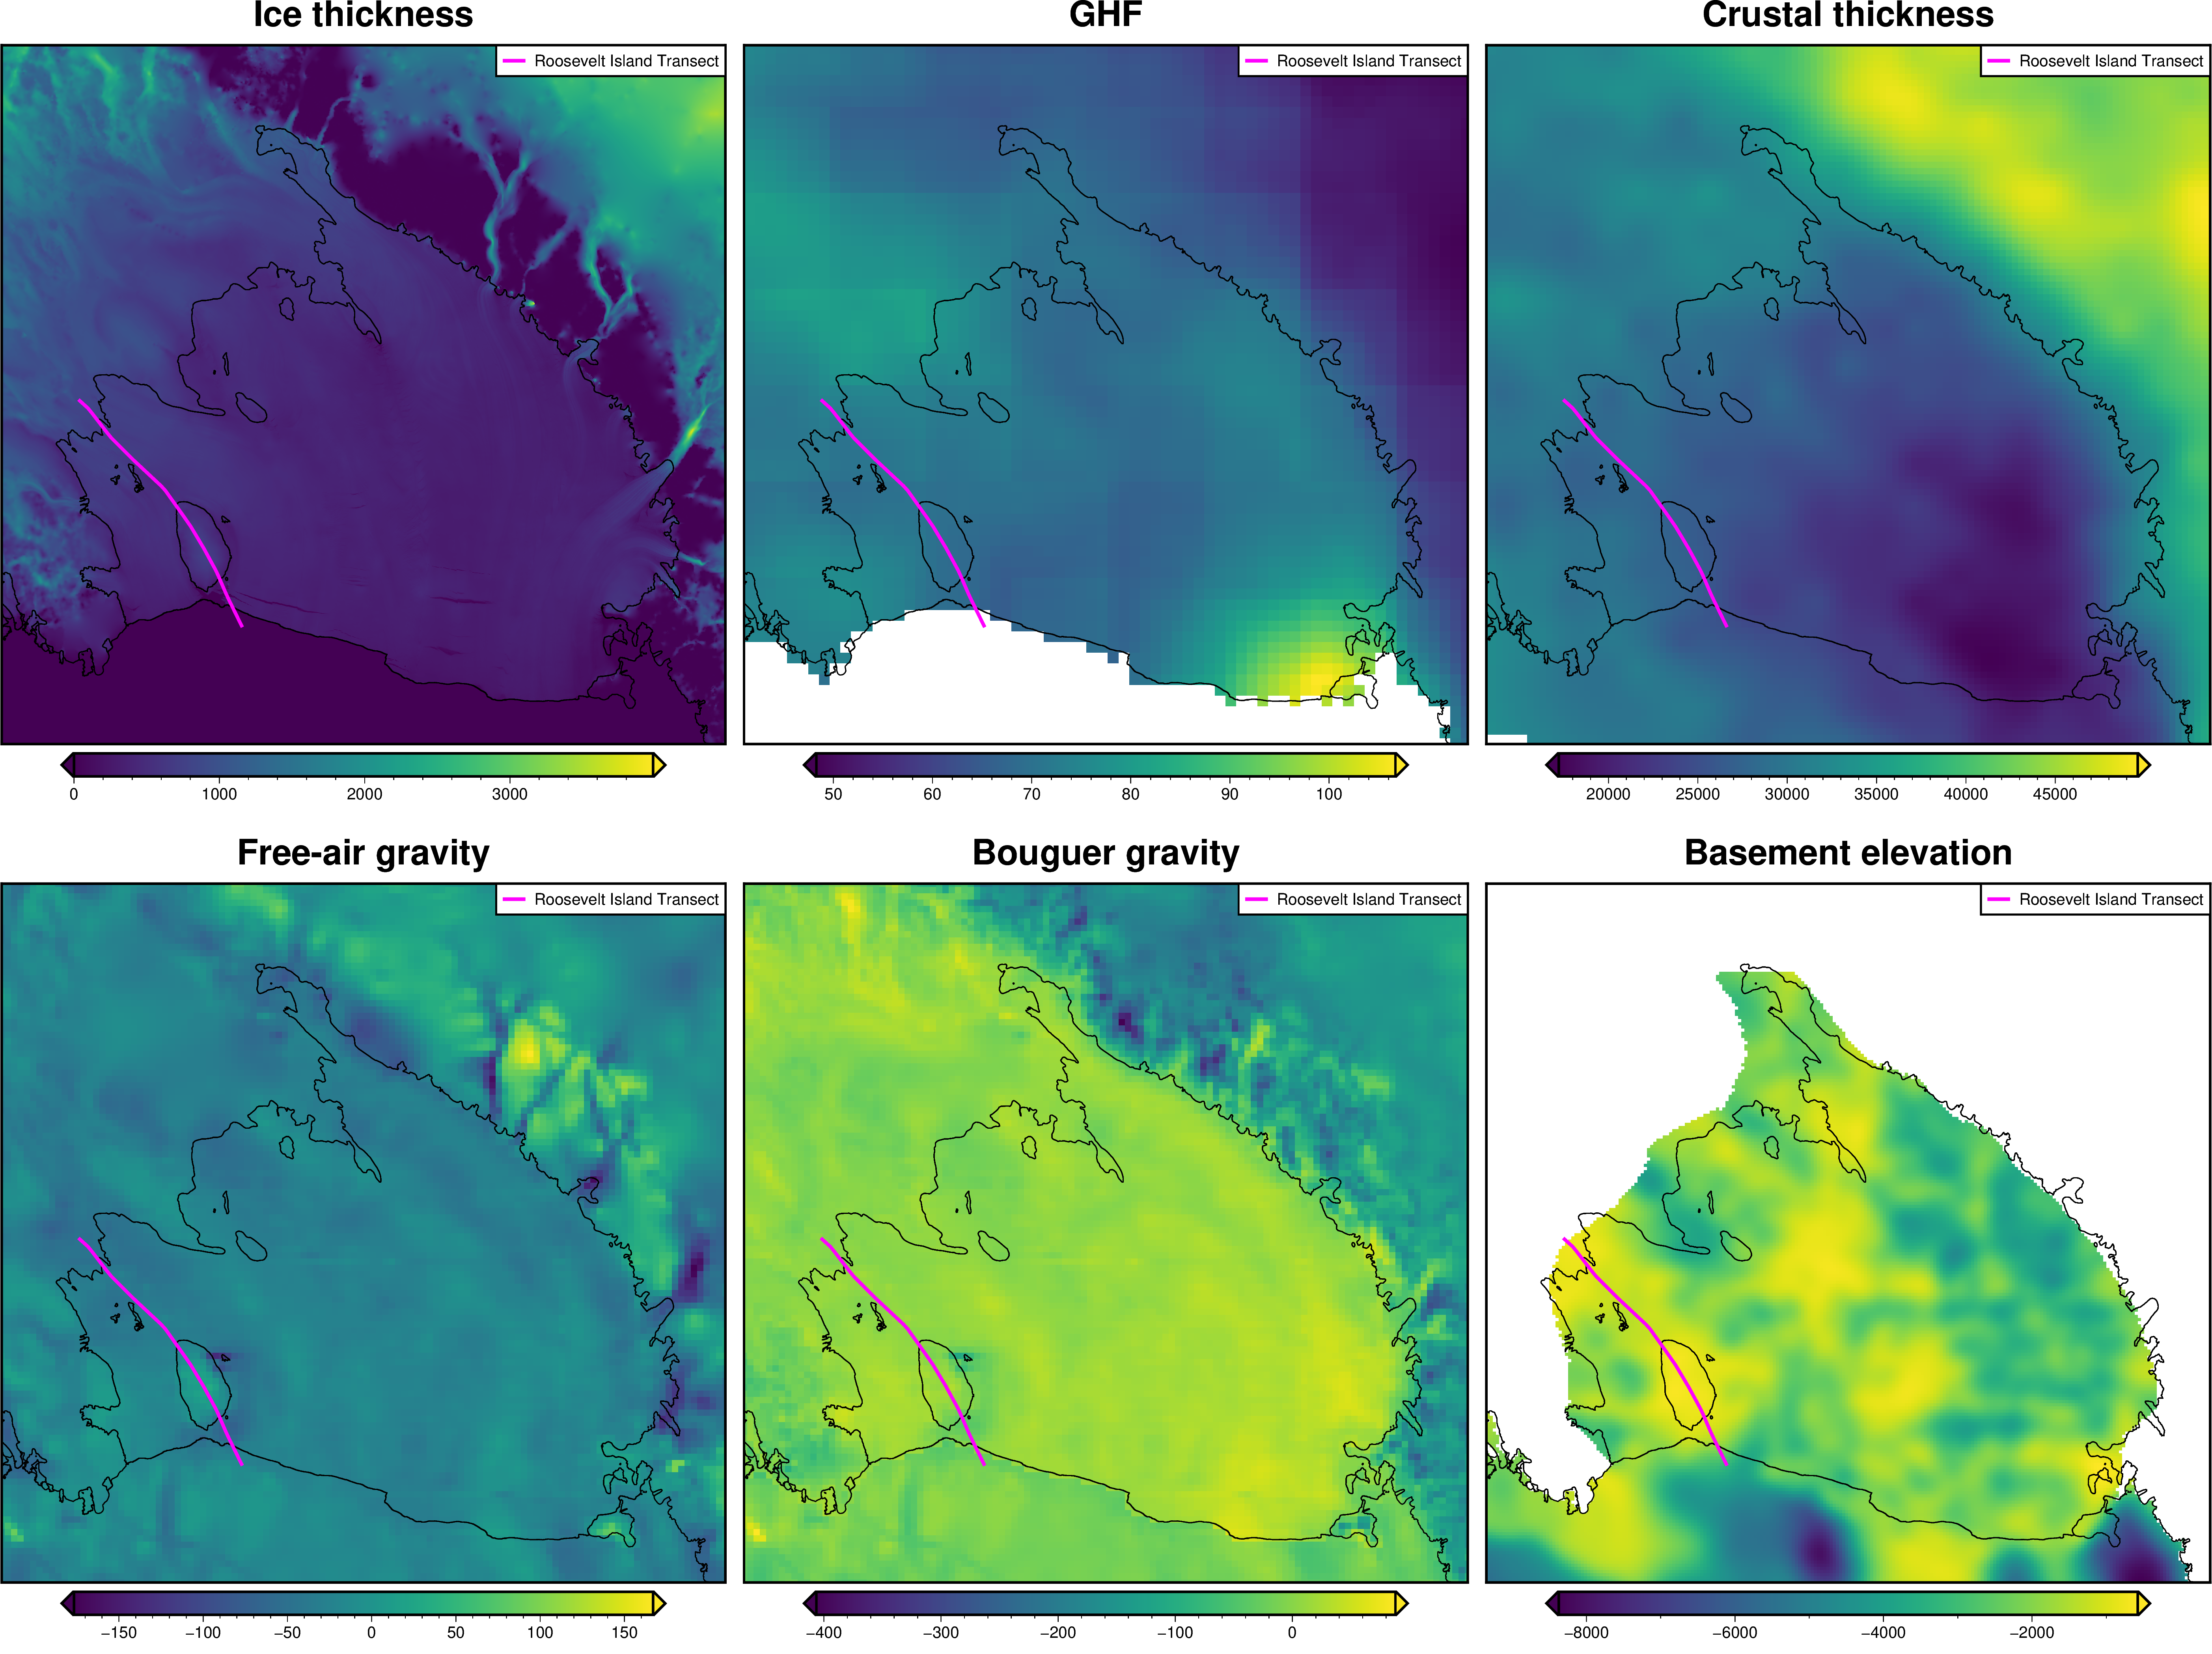

In [31]:
subplot_dimensions = utils.square_subplots(len(layers.items()))

# iterate through the grids in the dictionary
for i, (k, v) in enumerate(layers.items()):
    # for the first grid, need orgin_shift to be default
    if i == 0:
        fig = maps.plot_grd(
            v["grid"],
            title=k,
            region=plot_region,
            coast=True,
        )
        # plot a shapefile
        fig.plot(
            data=fetch.sample_shp(name="Roosevelt_Island"),
            pen="2p,magenta",
            label="Roosevelt Island Transect",
        )
        # add legend
        fig.legend(position="JTR+jTR", box="+gwhite+p1p")

    # for the end of each row (mulitples of the number of columns) need to
    # shift origin down and back to beginning
    elif i % subplot_dimensions[1] == 0:
        fig = maps.plot_grd(
            v["grid"],
            title=k,
            fig=fig,
            origin_shift="both_shift",
            xshift_amount=-(
                subplot_dimensions[0] - 1
            ),  # gives -2, shifts plot back by 2
            yshift_amount=-1,  # shift new row down by 1
            region=plot_region,
            coast=True,
        )
        # plot a shapefile
        fig.plot(
            data=fetch.sample_shp(name="Roosevelt_Island"),
            pen="2p,magenta",
            label="Roosevelt Island Transect",
        )
        # add legend
        fig.legend(position="JTR+jTR", box="+gwhite+p1p")

    # for the rest of the grids, just shift to the right like normal
    else:
        fig = maps.plot_grd(
            v["grid"],
            title=k,
            fig=fig,
            origin_shift="xshift",
            region=plot_region,
            coast=True,
        )
        # plot a shapefile
        fig.plot(
            data=fetch.sample_shp(name="Roosevelt_Island"),
            pen="2p,magenta",
            label="Roosevelt Island Transect",
        )
        # add legend
        fig.legend(position="JTR+jTR", box="+gwhite+p1p")

fig.show()